In this notebook i will start testing some of teh discoveries that i made in the EDA
For my first prediciton I will apply these ideas:
- District_price is a good feature
- Building_id is good ofr traning set, but not for test
- Lets just leave most missing values and let lightGBM use them
- Categorical features will be dealt with through lightGBM
- Will do one prediciton focusing on few, but important features
- And one with more features
- remove outliers from training data

In [87]:
from sklearn.model_selection import train_test_split
#imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import string
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from moscow_housing.display_data import import_data
import lightgbm as lgb


def one_hot_encode_multiple(df, list_of_columns):
    """takes in multiple columns and runs one hot encode for each column"""
    for column_to_encode in list_of_columns:
        print(column_to_encode)
        df = one_hot_encode(df, column_to_encode)
    return df

def one_hot_encode(df, column_to_encode):
    """one hots encode for one singel column"""
    encoded_df = pd.get_dummies(df[[column_to_encode]].astype(str))
    print(encoded_df.info())
    df = pd.concat([df,encoded_df],axis=1)
    return df

def add_high_up(df):
    """add exponetital function to determine how high up a building is"""
    high_up = df.floor/df.stories
    high_up_exp = np.exp(high_up) - 1
    euler = np.exp(1)

    df['high_up'] = high_up_exp
    df['high_up'].where(df['high_up'] > euler, euler)


    return df


def add_radius(df):
    """adds radius column to dataframe"""
    df['radius'] = np.sqrt((df['latitude']-55.75)**2 + (df['longitude']-37.56)**2)

    return df

def add_direction(df):
    """adds direction to dataframe, can be one of eight categories (N,S,W,E)"""
    #straight up (north)
    normal_vector = np.array([0,1])
    #normal_vector = np.tile(normal_vector,(df.shape[0],1))
    #normal_vector = normal_vector.reshape((2,-df.shape[0]))
    temp = pd.DataFrame()
    temp['latitude'] = df['latitude']-55.75
    temp['longitude'] = df['longitude']-37.56


    apartment_vector = temp[['latitude','longitude']].to_numpy()


    #print(np.shape(apartment_vector), np.shape(normal_vector))
    angles = []
    for vector in apartment_vector:
        if vector[0] < 0:
            temp_angle = -angle_between(vector,normal_vector)
        else:
            temp_angle = angle_between(vector,normal_vector)
        angles.append(temp_angle)

    angles = [element * 10 for element in angles]


    angles_series = pd.Series(np.array(angles))

    df['direction'] = angles_series
    max = df.direction.max().round()
    min = df.direction.min().round()

    bins = [min,min*7/8,min*5/8,min*3/8,min/8,max/8,max*3/8,max*5/8,max*7/8,max]
    rounded_bins = [element.round() for element in bins]
    #print(rounded_bins)

    direction = pd.cut(df.direction, bins= rounded_bins,labels=['S','SW','W','NW','N','NE','E','SE','S'],ordered=False)
    df['direction'] = direction
    return df

def unit_vector(vector):
    """returns the unit vector if the vector"""
    return vector/np.linalg.norm(vector)

def angle_between(v1,v2):
    """returns angle between two vectors in radian"""
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return np.arccos(np.clip(np.dot(v1_u,v2_u),-1,1))

def pair_plot(df, columns):
    #plots a pairplot with the sns libary
    sns.pairplot(df[columns],
    plot_kws={'alpha': 0.6},
    diag_kws={'bins': 30})

def plot_correlation(df):
    #plots correlation in a dataframe
    corr = df.corr()
    sns.heatmap(
    corr,
    linewidths=.5,
    annot=True,
    fmt='.1f'
    )

def group_by_feature_and_price(df, feature, data_train = pd.DataFrame()):
    #makes a new column with the mean price for each group to all rows
    if data_train.empty:
        grouped = df.groupby([feature])

        mean_price = grouped['price'].mean()

        df_merged = pd.merge(df,mean_price, on=feature, how='left')

        column_name = str(feature + '_price')

        df[column_name] = df_merged['price_y']
    else:
        grouped = data_train.groupby([feature])

        mean_price = grouped['price'].mean()

        df_merged = pd.merge(df,mean_price, on=feature, how='left')

        column_name = str(feature + '_price')

        df[column_name] = df_merged['price']
    return df

def fix_radius(data_test):
    """should just be called on test data"""
    #fix all radius issues
    data_test._set_value(23,'radius',0.203899)
    data_test._set_value(90,'radius',0.203899)
    data_test._set_value(2511,'radius',0.218159)
    data_test._set_value(5090,'radius',0.218159)
    data_test._set_value(6959,'radius',0.218159)
    data_test._set_value(8596,'radius',0.218159)
    data_test._set_value(4719, 'radius',0.19580)
    data_test._set_value(9547, 'radius',0.19520)
    data_test._set_value(2529, 'radius', np.sqrt((37.464994-37.55)**2+(55.627666-55.75)**2))

    return data_test

def drop_n_largest(data_train):
    """drops 4 largest values, should only be called on training set"""
    #drop 4 largest from training data, maybe not samrt, but we will see
    data_train.drop([3217,21414,15840,13938])
    return data_train

def clean_data(all_data):
    """cleans the data with all the knowledge we have so far"""


    #fix ceiling issues
    all_data.loc[all_data['ceiling'] > 50,'ceiling']*=0.01
    all_data.loc[all_data['ceiling'] > 25, 'ceiling']*=0.1
    all_data.loc[all_data['ceiling'] < 0.5,'ceiling'] = float('NaN')

    #fix area_kitchen and area_living issues
    all_data['living'] = all_data.area_living/all_data.area_total
    all_data['kitchen'] = all_data.area_total/all_data.area_kitchen

    all_data.loc[all_data['living'] > 1,'area_living'] = all_data['area_living'] * all_data['area_total']/100
    all_data.loc[all_data['living'] > 1,'area_kitchen'] = all_data['area_kitchen'] * all_data['area_total']/100

    all_data.loc[all_data.area_living/all_data.area_total > 1, 'area_living'] = float('NaN')

    all_data['living'] = all_data.area_living/all_data.area_total
    all_data['kitchen'] = all_data.area_kitchen/all_data.area_total

    all_data['sum_area'] = all_data.area_living + all_data.area_kitchen
    all_data.loc[all_data['sum_area'] == 100, 'area_living'] = all_data['area_living'] * all_data['area_total']/100
    all_data.loc[all_data['sum_area'] == 100, 'area_kitchen'] = all_data['area_kitchen'] * all_data['area_total']/100

    #this fixed some few rows.
    #when printing we see some other very clear "precentage situations, fixing these
    all_data.loc[all_data['sum_area'] == 38.5, 'area_living'] = all_data['area_living'] * all_data['area_total']/100
    all_data.loc[all_data['sum_area'] == 38.5, 'area_kitchen'] = all_data['area_kitchen'] * all_data['area_total']/100
    all_data.loc[all_data['sum_area'] == 52.7, 'area_living'] = all_data['area_living'] * all_data['area_total']/100
    all_data.loc[all_data['sum_area'] == 52.7, 'area_kitchen'] = all_data['area_kitchen'] * all_data['area_total']/100
    all_data.loc[all_data['sum_area'] == 71.6, 'area_living'] = all_data['area_living'] * all_data['area_total']/100
    all_data.loc[all_data['sum_area'] == 71.6, 'area_kitchen'] = all_data['area_kitchen'] * all_data['area_total']/100
    all_data.loc[(all_data['sum_area'] == 80) & (all_data['area_kitchen'] == 20), 'area_living'] = all_data['area_living'] * all_data['area_total']/100
    all_data.loc[(all_data['sum_area'] == 80) & (all_data['area_kitchen'] == 20), 'area_kitchen'] = all_data['area_kitchen'] * all_data['area_total']/100
    all_data.loc[(all_data['sum_area'] == 80) & (all_data['area_kitchen'] == 15), 'area_living'] = all_data['area_living'] * all_data['area_total']/100
    all_data.loc[(all_data['sum_area'] == 80) & (all_data['area_kitchen'] == 15), 'area_kitchen'] = all_data['area_kitchen'] * all_data['area_total']/100
    all_data.loc[(all_data['sum_area'] == 80) & (all_data['area_kitchen'] == 10), 'area_living'] = all_data['area_living'] * all_data['area_total']/100
    all_data.loc[(all_data['sum_area'] == 80) & (all_data['area_kitchen'] == 10), 'area_kitchen'] = all_data['area_kitchen'] * all_data['area_total']/100
    all_data.loc[(all_data['sum_area'] == 80) & (all_data['area_kitchen'] == 30), 'area_living'] = all_data['area_living'] * all_data['area_total']/100
    all_data.loc[(all_data['sum_area'] == 80) & (all_data['area_kitchen'] == 30), 'area_kitchen'] = all_data['area_kitchen'] * all_data['area_total']/100
    all_data.loc[(all_data['sum_area'] == 90) & (all_data['area_kitchen'] == 10), 'area_living'] = all_data['area_living'] * all_data['area_total']/100
    all_data.loc[(all_data['sum_area'] == 90) & (all_data['area_kitchen'] == 10), 'area_kitchen'] = all_data['area_kitchen'] * all_data['area_total']/100
    all_data.loc[(all_data['sum_area'] == 90) & (all_data['area_kitchen'] == 15), 'area_living'] = all_data['area_living'] * all_data['area_total']/100
    all_data.loc[(all_data['sum_area'] == 90) & (all_data['area_kitchen'] == 15), 'area_kitchen'] = all_data['area_kitchen'] * all_data['area_total']/100
    all_data.loc[(all_data['sum_area'] == 90) & (all_data['area_kitchen'] == 20), 'area_living'] = all_data['area_living'] * all_data['area_total']/100
    all_data.loc[(all_data['sum_area'] == 90) & (all_data['area_kitchen'] == 20), 'area_kitchen'] = all_data['area_kitchen'] * all_data['area_total']/100
    all_data.loc[(all_data['sum_area'] == 90) & (all_data['area_kitchen'] == 25), 'area_living'] = all_data['area_living'] * all_data['area_total']/100
    all_data.loc[(all_data['sum_area'] == 90) & (all_data['area_kitchen'] == 25), 'area_kitchen'] = all_data['area_kitchen'] * all_data['area_total']/100
    all_data.loc[(all_data['sum_area'] == 90) & (all_data['area_kitchen'] == 30), 'area_living'] = all_data['area_living'] * all_data['area_total']/100
    all_data.loc[(all_data['sum_area'] == 90) & (all_data['area_kitchen'] == 30), 'area_kitchen'] = all_data['area_kitchen'] * all_data['area_total']/100
    all_data.loc[(all_data['sum_area'] == 90) & (all_data['area_kitchen'] == 50), 'area_living'] = all_data['area_living'] * all_data['area_total']/100
    all_data.loc[(all_data['sum_area'] == 90) & (all_data['area_kitchen'] == 50), 'area_kitchen'] = all_data['area_kitchen'] * all_data['area_total']/100
    all_data.loc[(all_data['sum_area'] == 60) & (all_data['area_total'] > 120), 'area_living'] = all_data['area_living'] * all_data['area_total']/100
    all_data.loc[(all_data['sum_area'] == 60) & (all_data['area_total'] > 120), 'area_kitchen'] = all_data['area_kitchen'] * all_data['area_total']/100
    all_data.loc[(all_data['sum_area'] < 70) & (all_data['area_total'] > 120)&(all_data['rooms'] < 3), 'area_living'] = all_data['area_living'] * all_data['area_total']/100
    all_data.loc[(all_data['sum_area'] < 70) & (all_data['area_total'] > 120)&(all_data['rooms'] < 3), 'area_kitchen'] = all_data['area_kitchen'] * all_data['area_total']/100

    return all_data

def root_mean_squared_log_error(y_true, y_pred):
    # Alternatively: sklearn.metrics.mean_squared_log_error(y_true, y_pred) ** 0.5
    assert (y_true >= 0).all()
    assert (y_pred >= 0).all()
    log_error = np.log1p(y_pred) - np.log1p(y_true)  # Note: log1p(x) = log(1 + x)
    return np.mean(log_error ** 2) ** 0.5


#import the data and test data, set y values for both sets
data_train, data_test = import_data()
Y= data_train.price
test_id = data_test.id

#lets first add radius
data_train = add_radius(data_train)
data_test = add_radius(data_test)

#lets clean the data
data_test = fix_radius(data_test)
data_test = clean_data(data_test)
data_train = clean_data(data_train)


#lets add high up
data_train = add_high_up(data_train)
data_test = add_high_up(data_test)

#lets add direction
data_train = add_direction(data_train)
data_test = add_direction(data_test)

#Then we group by and add district price
data_train = group_by_feature_and_price(data_train,'district')
data_test = group_by_feature_and_price(data_test, 'district', data_train=data_train)

#then we chose which features to focus on
data_train_focus = data_train[['windows_street','stories','parking', 'new','district', 'elevator_without','condition','floor','high_up','district_price','radius','rooms','area_total']]
data_test_focus = data_test[['windows_street','stories','parking', 'new','district', 'elevator_without','condition','floor' ,'high_up','district_price','radius','rooms','area_total']]

#try with fewer attributes
data_train_focus = data_train[['windows_street','stories','parking', 'new','district', 'elevator_without','condition','floor','high_up','district_price','radius','rooms','area_total']]
data_test_focus = data_test[['windows_street','stories','parking', 'new','district', 'elevator_without','condition','floor' ,'high_up','district_price','radius','rooms','area_total']]


data_test_focus.info()
data_train_focus.info()

#determine which features is categorical
catergorical = ['parking', 'new', 'condition']
#'area_kitchen','area_living','bathrooms_shared','bathrooms_private','balconies','loggias'

#lets make the lightgbm model

#frist we should test it on the training set:
X_train, X_test, y_train, y_test = train_test_split(data_train_focus, Y, test_size=0.2, random_state=42)

lightGBM_model = lgb.LGBMRegressor(
    categorical_feature=(0,1,2,3,4,5,6,7),
    num_leaves=256,
    max_depth=8,
    random_state=42,
    metric='rmsle',
    num_iterations=2000,
    learning_rate=0.09,
    bagging_freq = 5,
    bagging_fraction = 0.8)

lightGBM_model.fit(X_train,y_train,categorical_feature=(0,1,2,3,4,5,6,7))
result = lightGBM_model.predict(X_test)

lgb.plot_importance(lightGBM_model)

prediction = result.copy()

count = 0
for i in prediction:
    if i < 0:
        print('predicted price: ',i, '\nreal price: ',data_train.loc[[count]].price, '\nmean_price: ',prediction.mean() )
        prediction[count] = prediction.mean()
        print(data_train.loc[[count]])
    count += 1

rmsle = root_mean_squared_log_error(y_test,prediction)
print("first run", rmsle)

prediction = result.copy()

lightGBM_model.fit(data_train_focus,Y,categorical_feature=(0,1,2,3,4,5,6,7))
prediction = lightGBM_model.predict(data_test_focus)

lgb.plot_importance(lightGBM_model)

count = 0
for i in prediction:
    if i < 0:
        print('predicted price: ',i, '\nmean_price: ',prediction.mean() )
        prediction[count] = prediction.mean()
        print(data_test_focus.loc[[count]])
    count += 1

submission = pd.DataFrame()
submission['id'] = test_id
submission['price_prediction'] = prediction

submission.to_csv('submission_lightGBM_EDA.csv', index= False)

In [88]:
#try with fewer attributes
#best so far
data_train_focus = data_train[['seller','material','district','condition','parking','new','direction','constructed','elevator_without','garbage_chute','loggias','layout','balconies','floor','high_up','rooms','area_total','radius','ceiling','area_kitchen','area_living']]
data_test_focus = data_test[['seller','material','district','condition','parking','new','direction','constructed','elevator_without','garbage_chute','loggias','layout','balconies','floor','high_up','rooms','area_total','radius','ceiling','area_kitchen','area_living']]

#all_data_focus = data_train[['area_total','floor','rooms','radius','new','district','high_up']]
#data_test_focus = data_test[['area_total','floor','rooms','radius','new','district','high_up']]


data_test_focus.info()
data_test_focus.info()

#determine which features is categorical
catergorical = ['parking', 'new', 'condition']
#'area_kitchen','area_living','bathrooms_shared','bathrooms_private','balconies','loggias'

#lets make the lightgbm model

#frist we should test it on the training set:
X_train, X_test, y_train, y_test = train_test_split(data_train_focus,Y, test_size=0.2, random_state=42)

lightGBM_model = lgb.LGBMRegressor(
    categorical_feature=(0,1,2,3,4,5,6,7,8,9,10,11,12),
    num_leaves=9**2,
    max_depth=9,
    random_state=42,
    metric='rmsle',
    num_iterations=1000,
    learning_rate=0.09,
    bagging_freq = 5,
    bagging_fraction = 0.8)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9937 entries, 0 to 9936
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   seller            5995 non-null   float64 
 1   material          8266 non-null   float64 
 2   district          9912 non-null   float64 
 3   condition         5978 non-null   float64 
 4   parking           7070 non-null   float64 
 5   new               9828 non-null   float64 
 6   direction         9872 non-null   category
 7   constructed       9563 non-null   float64 
 8   elevator_without  9757 non-null   float64 
 9   garbage_chute     6511 non-null   float64 
 10  loggias           5102 non-null   float64 
 11  layout            2569 non-null   float64 
 12  balconies         5102 non-null   float64 
 13  floor             9937 non-null   float64 
 14  high_up           9937 non-null   float64 
 15  rooms             9937 non-null   float64 
 16  area_total        9937 n

[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\Styrk\AppData\Local\Programs\Python\Python39\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\Styrk\AppData\Local\Programs\Python\Python39\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\Styrk\AppData\Local\Programs\Python\Python39\lib\site-packages\lightgbm\basic.py:1222: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning('{0} keyword has been found in `params` and will be ignored.\n'
C:\Users\Styrk\AppData\Local\Programs\Python\Python39\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_feature in param dict is overridden.
  _log_warning('{} in p

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

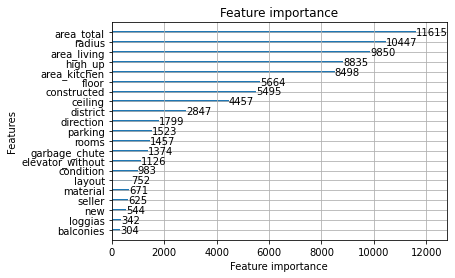

In [89]:
lightGBM_model.fit(X_train,np.log(y_train)/np.log(15),categorical_feature=(0,1,2,3,4,5,6,7,8,9,10,11,12))
result = lightGBM_model.predict(X_test)

lgb.plot_importance(lightGBM_model)

In [90]:
prediction = result.copy()

count = 0
for i in prediction:
    if i < 0:
        print('predicted price: ',i, '\nreal price: ',data_train.loc[[count]].price, '\nmean_price: ',prediction.mean() )
        prediction[count] = prediction.mean()
        print(data_train.loc[[count]])
    count += 1

rmsle = root_mean_squared_log_error(y_test,15**prediction)
print("first run", rmsle)

first run 0.14279105438974912


[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


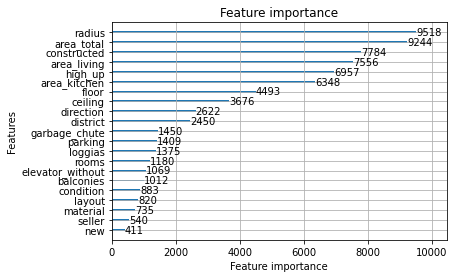

In [91]:
prediction = result.copy()

lightGBM_model.fit(data_train_focus,np.log10(Y),categorical_feature=(0,1,2,3,4))
prediction = lightGBM_model.predict(data_test_focus)

lgb.plot_importance(lightGBM_model)

count = 0
for i in prediction:
    if i < 0:
        print('predicted price: ',i, '\nmean_price: ',prediction.mean() )
        prediction[count] = prediction.mean()
        print(data_test_focus.loc[[count]])
    count += 1

submission = pd.DataFrame()
submission['id'] = test_id
submission['price_prediction'] = 10**prediction

submission.to_csv('submission_lightGBM_EDA.csv', index= False)